In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, precision_recall_curve, confusion_matrix,
                             classification_report, average_precision_score)
from sklearn.preprocessing import LabelEncoder
from itertools import cycle


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/merged_V2.csv')

In [ ]:
df = df.drop('image_filename', axis=1)

In [ ]:
encoder = LabelEncoder()
encoder.fit(df['label'])

df["label"] = encoder.transform(df['label'])
df
# 0 = jump, 1 = spin, 2 = step

,Nose_x,Nose_y,LEye_x,LEye_y,REye_x,REye_y,LEar_x,LEar_y,REar_x,REar_y,...,RSmallToe_x,RSmallToe_y,LHeel_x,LHeel_y,RHeel_x,RHeel_y,gender,level,label,path
0,1368.317139,245.318161,1375.947510,242.774719,1368.317139,240.231262,1388.664673,245.318161,1386.121338,245.318161,...,1355.599976,464.054596,1383.577881,456.424255,1386.121338,456.424255,0,1,0,Jump/1F(Flip)/넘어짐/고급/FA10/1/camera0/video/Moti...
1,1367.379517,245.956863,1375.112671,240.801453,1367.379517,240.801453,1388.001221,245.956863,1385.423462,245.956863,...,1354.490967,462.483887,1385.423462,457.328491,1385.423462,457.328491,0,1,0,Jump/1F(Flip)/넘어짐/고급/FA10/1/camera0/video/Moti...
2,1365.833862,248.601212,1373.505005,243.487152,1365.833862,243.487152,1386.290161,246.044174,1383.733032,246.044174,...,1355.605835,463.391479,1381.176025,458.277435,1388.847168,455.720398,0,1,0,Jump/1F(Flip)/넘어짐/고급/FA10/1/camera0/video/Moti...
3,1365.026855,247.695007,1372.763184,242.537491,1365.026855,242.537491,1385.656982,247.695007,1380.499390,245.116257,...,1354.711914,464.310516,1380.499390,459.152985,1388.235718,456.574249,0,1,0,Jump/1F(Flip)/넘어짐/고급/FA10/1/camera0/video/Moti...
4,1362.091553,247.426620,1369.815674,242.277222,1364.666260,239.702530,1382.689209,247.426620,1380.114502,247.426620,...,1354.367432,463.701385,1387.838623,458.551971,1387.838623,455.977264,0,1,0,Jump/1F(Flip)/넘어짐/고급/FA10/1/camera0/video/Moti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196118,559.091370,499.368195,572.020142,486.439392,554.781799,490.748993,593.568176,486.439392,550.472168,490.748993,...,567.710571,857.064819,628.044922,835.516846,597.877747,831.207275,1,1,2,Step/Stroking/정상/고급/FA02/5/camera7/video/Motio...
10196119,554.186768,501.605377,567.189575,492.936859,549.852478,492.936859,588.860901,488.602570,545.518188,492.936859,...,558.520996,861.349731,623.535034,844.012634,593.195190,835.344116,1,1,2,Step/Stroking/정상/고급/FA02/5/camera7/video/Motio...
10196120,549.747192,505.713135,562.702026,497.076569,541.110596,497.076569,584.293457,492.758270,536.792297,497.076569,...,554.065430,868.449341,618.839783,851.176208,588.611755,842.539612,1,1,2,Step/Stroking/정상/고급/FA02/5/camera7/video/Motio...
10196121,546.955139,513.225098,555.495850,500.414032,538.414429,504.684387,581.117920,496.143677,534.144104,504.684387,...,546.955139,871.934265,611.010376,859.123230,581.117920,850.582520,1,1,2,Step/Stroking/정상/고급/FA02/5/camera7/video/Motio...


In [ ]:
import numpy as np

def add_adversarial_noise_optimized(df, epsilon=2.0):
    # 필요한 컬럼 리스트
    sma_columns = [col for col in df.columns if col.endswith("_SMA") and ('_x' in col or '_y' in col)]
    # 원본 복사는 최소한으로 (필요한 부분만 복사)
    df_adv = df.copy(deep=False)  # 얕은 복사: 메모리 사용량이 줄어듦 (단, 내부 데이터가 수정되면 원본에도 영향이 있을 수 있음)

    # 모든 SMA 컬럼에 대해 한 번에 noise 행렬 생성 후 적용
    noise = np.random.uniform(-epsilon, epsilon, size=(df_adv.shape[0], len(sma_columns)))
    df_adv.loc[:, sma_columns] = df_adv.loc[:, sma_columns] + noise
    return df_adv

# 최적화된 함수 사용
df_adv = add_adversarial_noise_optimized(df, epsilon=2.0)

In [ ]:
X = df.drop(['label', 'level', 'gender', 'path'], axis=1)
Y = df['label']

print(X.shape)
print(Y.shape)

(10196123, 52)
(10196123,)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y, test_size=0.2, random_state=42, stratify = Y
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(6525518, 52)
(2039225, 52)
(6525518,)
(2039225,)
(1631380, 52)
(1631380,)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import numpy as np

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=False)

X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y.values, dtype=torch.long)

print(f"Total dataset size: {X_tensor.shape}")
print(f"Using {n_splits}-fold cross-validation")

Total dataset size: torch.Size([10196123, 52])
Using 5-fold cross-validation


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
def dataloader(X_train, Y_train, X_val, Y_val, batch_size=64):
    train_dataset = CustomDataset(X_train, Y_train)
    val_dataset = CustomDataset(X_val, Y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(1))  # (batch, seq_len=1, features)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력 사용
        return out


In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_classes, num_heads=4, hidden_dim=128, num_layers=2):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.transformer_encoder(x.unsqueeze(1))  # (batch, seq_len=1, features)
        x = self.fc(x[:, -1, :])  # 마지막 타임스텝의 출력 사용
        return x


In [ ]:
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=1e-4, device="cuda"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct, total = 0, 0

        # Training loop
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y_batch).sum().item()
            total += Y_batch.size(0)

        train_acc = correct / total

        # Validation loop
        model.eval()  # 평가 모드 전환
        val_loss = 0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == Y_batch).sum().item()
                total_val += Y_batch.size(0)

        val_acc = correct_val / total_val

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

    return model


def get_predictions(model, test_loader, device="cuda"):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)  # 확률로 변환
            all_probs.append(probs.cpu().numpy())
    return np.concatenate(all_probs, axis=0)




In [ ]:
# Test Set을 NumPy 배열로 변환 후 PyTorch Tensor로 변환
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)

# Test Dataset & DataLoader 생성
test_dataset = CustomDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Test set size: {len(test_dataset)} samples")

Test set size: 2039225 samples


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(np.unique(Y))  # 클래스 개수
input_size = X.shape[1]  # 입력 특성 개수

# 테스트셋 샘플 수와 클래스 수를 이용해 예측 확률 누적 배열 생성
ensemble_lstm_probs = np.zeros((len(test_dataset), num_classes))
ensemble_transformer_probs = np.zeros((len(test_dataset), num_classes))


# K-Fold 학습 및 각 fold 모델의 예측값 누적
for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor, Y_tensor)):
    print(f" Fold {fold+1}/{n_splits}")

    # 데이터 분할
    X_train_fold, Y_train_fold = X_tensor[train_idx], Y_tensor[train_idx]
    X_val_fold, Y_val_fold = X_tensor[val_idx], Y_tensor[val_idx]

    train_loader, val_loader = dataloader(X_train_fold, Y_train_fold, X_val_fold, Y_val_fold, batch_size=32)

    # LSTM 모델 학습
    lstm_model = LSTMModel(input_size=input_size, hidden_size=64, num_layers=2, num_classes=num_classes)
    print(" Training LSTM Model")
    trained_lstm = train_model(lstm_model, train_loader, val_loader, epochs=7, device=device)

    # Transformer 모델 학습
    transformer_model = TransformerModel(input_size=input_size, num_classes=num_classes, num_heads=4, hidden_dim=128, num_layers=2)
    print(" Training Transformer Model")
    trained_transformer = train_model(transformer_model, train_loader, val_loader, epochs=7, device=device)

    # 각 fold의 모델로 테스트셋 예측 (확률)
    lstm_fold_probs = get_predictions(trained_lstm, test_loader, device=device)
    transformer_fold_probs = get_predictions(trained_transformer, test_loader, device=device)

    # 각 fold의 예측값을 누적 (앙상블을 위해)
    ensemble_lstm_probs += lstm_fold_probs
    ensemble_transformer_probs += transformer_fold_probs



 Fold 1/5
 Training LSTM Model
Epoch 1/7, Train Loss: 1.0222, Train Acc: 0.4771, Val Loss: 1.0258, Val Acc: 0.4631
Epoch 2/7, Train Loss: 1.0143, Train Acc: 0.4847, Val Loss: 1.0049, Val Acc: 0.4855
Epoch 3/7, Train Loss: 1.0114, Train Acc: 0.4886, Val Loss: 0.9958, Val Acc: 0.5123
Epoch 4/7, Train Loss: 1.0165, Train Acc: 0.4884, Val Loss: 1.0058, Val Acc: 0.5170
Epoch 5/7, Train Loss: 1.0133, Train Acc: 0.4894, Val Loss: 1.0100, Val Acc: 0.4994
Epoch 6/7, Train Loss: 1.0096, Train Acc: 0.4899, Val Loss: 0.9963, Val Acc: 0.4913
Epoch 7/7, Train Loss: 1.0086, Train Acc: 0.4905, Val Loss: 0.9972, Val Acc: 0.5085
 Training Transformer Model


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/7, Train Loss: 0.8828, Train Acc: 0.5856, Val Loss: 0.9213, Val Acc: 0.5786
Epoch 2/7, Train Loss: 0.7828, Train Acc: 0.6456, Val Loss: 0.9250, Val Acc: 0.5627
Epoch 3/7, Train Loss: 0.7395, Train Acc: 0.6697, Val Loss: 0.8998, Val Acc: 0.5806
Epoch 4/7, Train Loss: 0.7142, Train Acc: 0.6829, Val Loss: 0.9048, Val Acc: 0.5762
Epoch 5/7, Train Loss: 0.6895, Train Acc: 0.6965, Val Loss: 0.9417, Val Acc: 0.5650
Epoch 6/7, Train Loss: 0.6707, Train Acc: 0.7063, Val Loss: 0.9361, Val Acc: 0.5729
Epoch 7/7, Train Loss: 0.6587, Train Acc: 0.7125, Val Loss: 0.9651, Val Acc: 0.5625
 Fold 2/5
 Training LSTM Model
Epoch 1/7, Train Loss: 1.0151, Train Acc: 0.4803, Val Loss: 1.0149, Val Acc: 0.5065
Epoch 2/7, Train Loss: 1.0078, Train Acc: 0.4877, Val Loss: 1.0126, Val Acc: 0.4907
Epoch 3/7, Train Loss: 1.0074, Train Acc: 0.4893, Val Loss: 1.0148, Val Acc: 0.4862
Epoch 4/7, Train Loss: 1.0013, Train Acc: 0.4940, Val Loss: 1.0154, Val Acc: 0.4893
Epoch 5/7, Train Loss: 0.9949, Train Acc: 0.4

In [ ]:
# 각 모델의 예측 확률을 평균 내어 최종 예측값 도출
ensemble_lstm_probs /= n_splits
ensemble_transformer_probs /= n_splits

# 예측 확률에서 최종 클래스 라벨 도출 (argmax)
ensemble_lstm_preds = np.argmax(ensemble_lstm_probs, axis=1)
ensemble_transformer_preds = np.argmax(ensemble_transformer_probs, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print("=== LSTM Ensemble Evaluation ===")
print("Classification Report:")
print(classification_report(Y_test.values, ensemble_lstm_preds))
print("Confusion Matrix:")
print(confusion_matrix(Y_test.values, ensemble_lstm_preds))

print("\n=== Transformer Ensemble Evaluation ===")
print("Classification Report:")
print(classification_report(Y_test.values, ensemble_transformer_preds))
print("Confusion Matrix:")
print(confusion_matrix(Y_test.values, ensemble_transformer_preds))


=== LSTM Ensemble Evaluation ===
Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.57      0.71      0.63    921106
           1       0.43      0.58      0.49    656960
           2       0.00      0.00      0.00    461159

    accuracy                           0.51   2039225
   macro avg       0.33      0.43      0.37   2039225
weighted avg       0.39      0.51      0.44   2039225

Confusion Matrix:
[[650941 270165      0]
 [275559 381401      0]
 [221193 239966      0]]

=== Transformer Ensemble Evaluation ===
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79    921106
           1       0.74      0.67      0.70    656960
           2       0.69      0.63      0.66    461159

    accuracy                           0.73   2039225
   macro avg       0.73      0.71      0.72   2039225
weighted avg       0.73      0.73      0.73   2039225

Confusion Matrix:
[[770116  92276  58714]
 [147500 439770  69690]
 [112738  59618 2

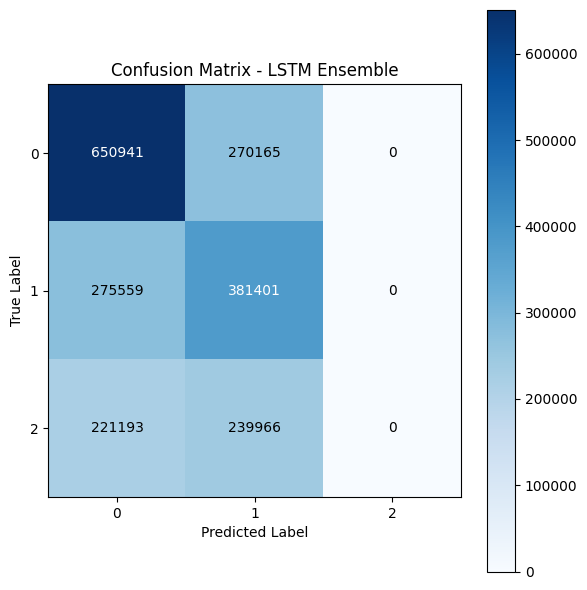

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 혼동 행렬 계산
cm = confusion_matrix(Y_test.values, ensemble_lstm_preds)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LSTM Ensemble")
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# 셀 값 표시
fmt = 'd'
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# 다중 클래스의 경우 True 라벨을 바이너리화
classes = np.unique(Y_test.values)
n_classes = len(classes)
Y_test_bin = label_binarize(Y_test.values, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], ensemble_lstm_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(Y_test_bin[:, i], ensemble_lstm_probs[:, i])
    avg_precision[i] = average_precision_score(Y_test_bin[:, i], ensemble_lstm_probs[:, i])


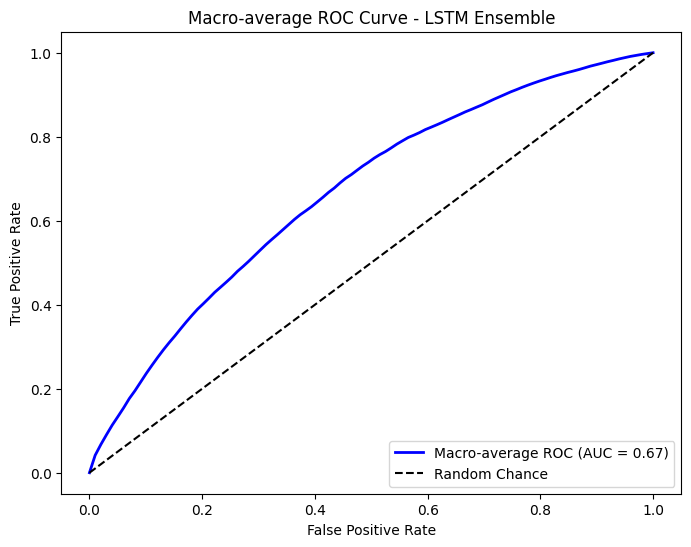

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# 공통 fpr 값: 0부터 1까지 100 포인트
all_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(all_fpr)

# 각 클래스별로 fpr, tpr를 공통 fpr에 대해 보간(interpolate)한 후 평균
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

# macro-average AUC 계산
macro_auc = auc(all_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
plt.plot(all_fpr, mean_tpr, color="b", lw=2,
         label=f"Macro-average ROC (AUC = {macro_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-average ROC Curve - LSTM Ensemble")
plt.legend(loc="lower right")
plt.show()


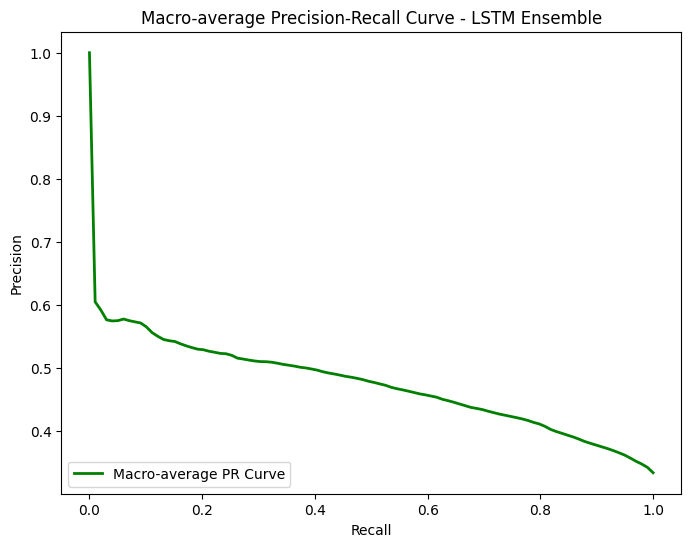

Macro-average PR Curve (Precision values):
[1.         0.60453832 0.59154668 0.57606389 0.57423225 0.57473535
 0.57726363 0.5746629  0.57281572 0.57098306 0.56480631 0.55573505
 0.54988945 0.54489453 0.54286372 0.54164824 0.5379148  0.53471643
 0.53191032 0.52946855 0.52857309 0.52615344 0.52449873 0.52271762
 0.52215543 0.51962359 0.5151831  0.51377061 0.51214727 0.51073921
 0.50972394 0.50956078 0.5087458  0.50718336 0.50534752 0.50396829
 0.50259439 0.50077607 0.49966239 0.49798847 0.49618646 0.49361406
 0.49162651 0.49006386 0.48824694 0.48630879 0.48489201 0.4831395
 0.48119018 0.47856232 0.47660467 0.4743016  0.47211631 0.46892585
 0.4666763  0.46487785 0.46281125 0.46067217 0.45850375 0.45690821
 0.45506352 0.45313459 0.44984586 0.44766233 0.44518775 0.44240588
 0.4397549  0.43699664 0.43539328 0.43360318 0.43103181 0.42871633
 0.42641146 0.42458545 0.42266303 0.4207959  0.41874944 0.41632336
 0.41326574 0.410755   0.40699595 0.40208456 0.39865206 0.39585052
 0.39283506 0.389975

In [ ]:
# 공통 recall 값: 0부터 1까지 100 포인트
all_recall = np.linspace(0, 1, 100)
mean_precision = np.zeros_like(all_recall)

for i in range(n_classes):
    # recall, precision 값은 보통 내림차순이 아닌 경우도 있으므로, 보간 전에 정렬합니다.
    sorted_idx = np.argsort(recall[i])
    sorted_recall = recall[i][sorted_idx]
    sorted_precision = precision[i][sorted_idx]
    mean_precision += np.interp(all_recall, sorted_recall, sorted_precision)
mean_precision /= n_classes

plt.figure(figsize=(8, 6))
plt.plot(all_recall, mean_precision, color="g", lw=2,
         label="Macro-average PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-average Precision-Recall Curve - LSTM Ensemble")
plt.legend(loc="lower left")
plt.show()

print("Macro-average PR Curve (Precision values):")
print(mean_precision)

In [ ]:
from sklearn.calibration import calibration_curve

# 각 클래스별 calibration curve를 저장할 딕셔너리 생성
calib_pred_lstm = dict()
calib_frac_lstm = dict()

for i in range(n_classes):
    # Y_test_bin[:, i]: 이진화된 true label, ensemble_lstm_probs[:, i]: 해당 클래스의 예측 확률
    frac, pred_val = calibration_curve(Y_test_bin[:, i], ensemble_lstm_probs[:, i], n_bins=10)
    calib_pred_lstm[i] = pred_val
    calib_frac_lstm[i] = frac


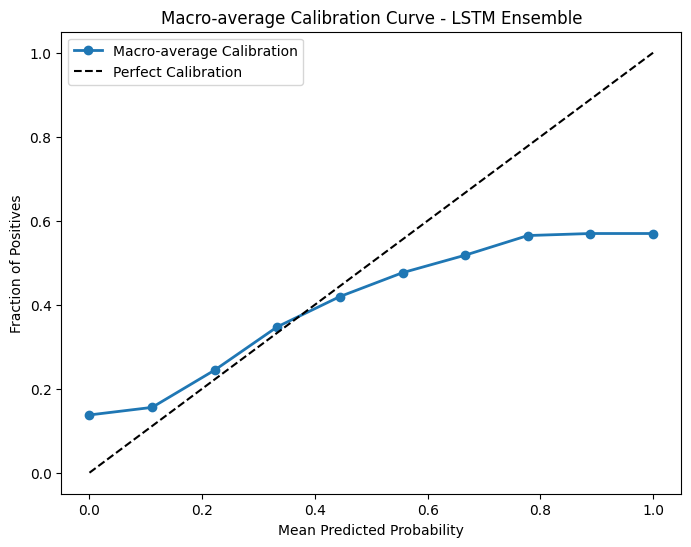

Macro-average Calibration Curve (Fraction values):
[0.13756356 0.15557389 0.24435207 0.34749626 0.41947917 0.4762824
 0.51796806 0.56471028 0.56955719 0.56955719]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 공통 x축: 평균 predicted probability (n_bins 값과 동일하게 사용, 예: 10 포인트)
n_bins = 10
common_pred = np.linspace(0, 1, n_bins)
mean_frac = np.zeros_like(common_pred)

for i in range(n_classes):
    # 각 클래스별 calib_pred_lstm[i]와 calib_frac_lstm[i]에 대해 common_pred 기준 보간
    mean_frac += np.interp(common_pred, calib_pred_lstm[i], calib_frac_lstm[i])
mean_frac /= n_classes

plt.figure(figsize=(8, 6))
plt.plot(common_pred, mean_frac, marker='o', lw=2, label="Macro-average Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Macro-average Calibration Curve - LSTM Ensemble")
plt.legend(loc="best")
plt.show()

print("Macro-average Calibration Curve (Fraction values):")
print(mean_frac)


In [ ]:
# # ROC Curve 그리기
# plt.figure(figsize=(8, 6))
# for i in range(n_classes):
#     plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
# plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves - LSTM Ensemble")
# plt.legend(loc="lower right")
# plt.show()

# # Precision-Recall Curve 그리기
# plt.figure(figsize=(8, 6))
# for i in range(n_classes):
#     plt.plot(recall[i], precision[i], label=f"Class {i} (AP = {avg_precision[i]:.2f})")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curves - LSTM Ensemble")
# plt.legend(loc="lower left")
# plt.show()


=== Evaluating LSTM Ensemble ===
Test Accuracy: 0.5062
Error Rate: 0.4938


<ipython-input-25-5ac930d5dd93>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


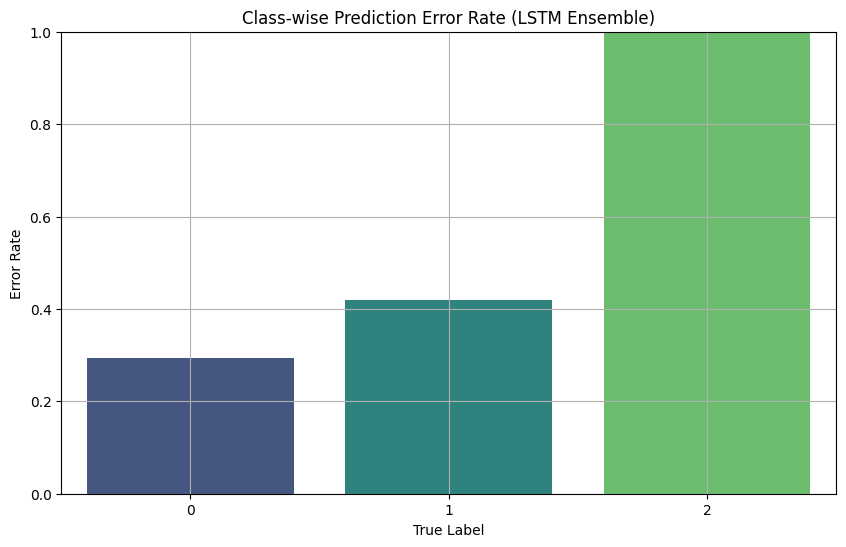

Class-wise Error Rate:
True Label
0    0.293305
1    0.419446
2    1.000000
Name: Error, dtype: float64

=== Evaluating Transformer Ensemble ===
Test Accuracy: 0.7349
Error Rate: 0.2651


<ipython-input-25-5ac930d5dd93>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


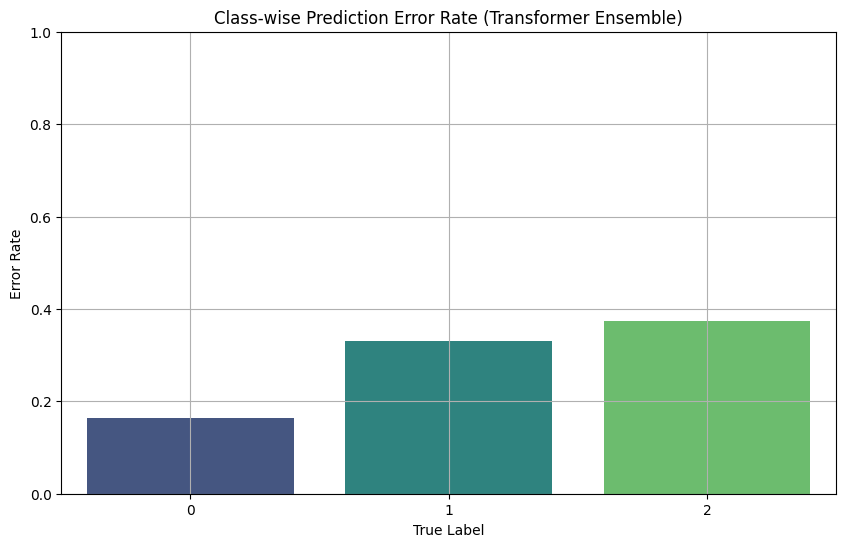

Class-wise Error Rate:
True Label
0    0.163923
1    0.330599
2    0.373745
Name: Error, dtype: float64


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 앙상블 예측 결과를 딕셔너리로 정리 (이미 ensemble_lstm_preds, ensemble_transformer_preds가 계산되어 있다고 가정)
ensemble_preds = {
    "LSTM": ensemble_lstm_preds,
    "Transformer": ensemble_transformer_preds
}

for name, preds in ensemble_preds.items():
    print(f"\n=== Evaluating {name} Ensemble ===")

    # Accuracy 및 Error Rate 계산
    accuracy = (Y_test.values == preds).mean()  # numpy 배열 비교 후 평균 계산
    error_rate = 1 - accuracy
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {error_rate:.4f}")

    # 예측 오류 분석을 위한 DataFrame 생성
    error_df = pd.DataFrame({
        "True Label": Y_test.values,
        "Predicted Label": preds
    })
    error_df["Error"] = (error_df["True Label"] != error_df["Predicted Label"]).astype(int)
    classwise_error = error_df.groupby("True Label")["Error"].mean()

    # 클래스별 오류 비율 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")
    plt.title(f"Class-wise Prediction Error Rate ({name} Ensemble)")
    plt.xlabel("True Label")
    plt.ylabel("Error Rate")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    print("Class-wise Error Rate:")
    print(classwise_error)


In [ ]:
# Accuracy 및 Error Rate 계산
accuracy = np.sum(Y_test.values == ensemble_lstm_preds) / len(Y_test.values)
error_rate = 1 - accuracy

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Error Rate: {error_rate:.4f}")


Test Accuracy: 0.5062
Error Rate: 0.4938


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.calibration import calibration_curve

# plt.figure(figsize=(8, 6))
# for i in range(n_classes):
#     fraction_of_positives, mean_predicted_value = calibration_curve(Y_test_bin[:, i], ensemble_lstm_probs[:, i], n_bins=10)
#     plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f"Class {i}")
# plt.plot([0, 1], [0, 1], 'k--', label="Perfectly Calibrated")
# plt.xlabel("Mean Predicted Probability")
# plt.ylabel("Fraction of Positives")
# plt.title("Calibration Curves - LSTM Ensemble")
# plt.legend(loc="best")
# plt.show()


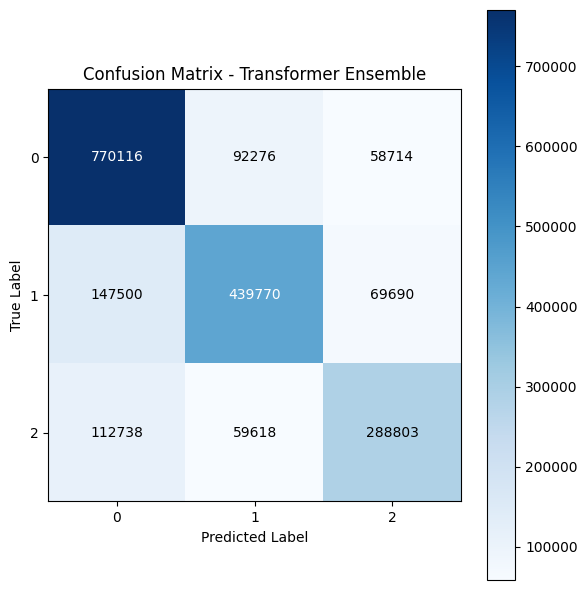

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 혼동 행렬 계산
cm_trans = confusion_matrix(Y_test.values, ensemble_transformer_preds)

plt.figure(figsize=(6, 6))
plt.imshow(cm_trans, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Transformer Ensemble")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# 셀 값 표시
fmt = 'd'
thresh = cm_trans.max() / 2.0
for i in range(cm_trans.shape[0]):
    for j in range(cm_trans.shape[1]):
        plt.text(j, i, format(cm_trans[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm_trans[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


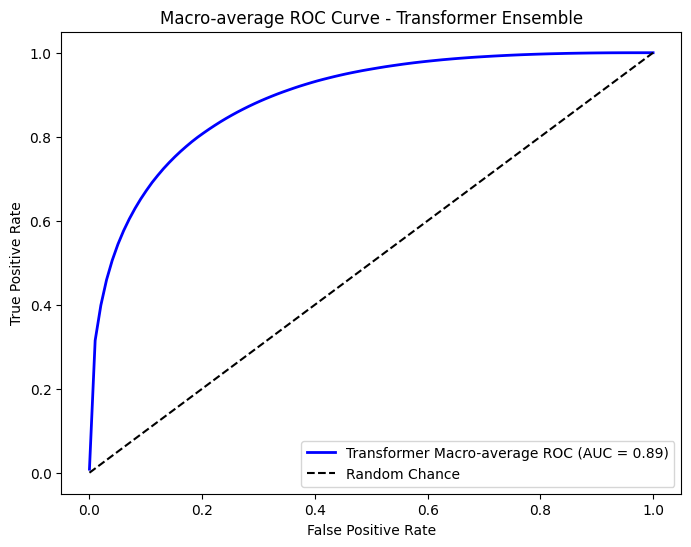

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 0부터 1까지 100 포인트의 공통 FPR 축
all_fpr = np.linspace(0, 1, 100)
mean_tpr_transformer = np.zeros_like(all_fpr)

# 각 클래스별 ROC Curve 계산 및 보간 후 평균 내기
fpr_transformer = dict()
tpr_transformer = dict()
roc_auc_transformer = dict()

for i in range(n_classes):
    fpr_transformer[i], tpr_transformer[i], _ = roc_curve(Y_test_bin[:, i], ensemble_transformer_probs[:, i])
    roc_auc_transformer[i] = auc(fpr_transformer[i], tpr_transformer[i])
    mean_tpr_transformer += np.interp(all_fpr, fpr_transformer[i], tpr_transformer[i])
mean_tpr_transformer /= n_classes

macro_auc_transformer = auc(all_fpr, mean_tpr_transformer)

plt.figure(figsize=(8, 6))
plt.plot(all_fpr, mean_tpr_transformer, color="b", lw=2,
         label=f"Transformer Macro-average ROC (AUC = {macro_auc_transformer:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-average ROC Curve - Transformer Ensemble")
plt.legend(loc="lower right")
plt.show()


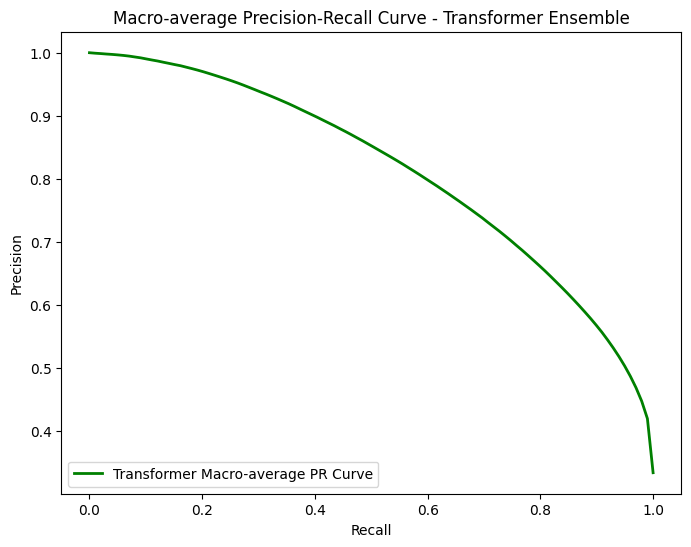

Macro-average PR Curve (Precision values):
[1.         0.99923572 0.99862366 0.99790933 0.99729693 0.99653121
 0.99566542 0.99459726 0.99321867 0.99188039 0.99012194 0.98841601
 0.98679682 0.98486523 0.98302659 0.98113832 0.9793636  0.97705894
 0.97477205 0.97236784 0.9698028  0.96703462 0.96420044 0.96131964
 0.95838408 0.95531512 0.95211492 0.94870126 0.94515115 0.94156951
 0.93791885 0.93437396 0.93067297 0.92687427 0.92296153 0.91902295
 0.91482507 0.91047578 0.90616943 0.90189566 0.89759622 0.8930898
 0.8886052  0.88414164 0.87938561 0.87475178 0.86991876 0.86494277
 0.8600565  0.85490332 0.84976338 0.8445577  0.83937848 0.83413681
 0.82879811 0.82336259 0.81769783 0.81206971 0.80633173 0.80043595
 0.79453347 0.78867821 0.78255888 0.77647383 0.77016339 0.76390271
 0.75745715 0.7510511  0.74440156 0.73778742 0.73062681 0.72365524
 0.71667452 0.70936822 0.70191536 0.69414075 0.68650855 0.67852199
 0.67039878 0.66220058 0.65378264 0.6450476  0.6360931  0.62713404
 0.61792669 0.608422

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# 0부터 1까지 100 포인트의 공통 Recall 축
all_recall = np.linspace(0, 1, 100)
mean_precision_transformer = np.zeros_like(all_recall)

precision_transformer = dict()
recall_transformer = dict()
avg_precision_transformer = dict()

for i in range(n_classes):
    precision_transformer[i], recall_transformer[i], _ = precision_recall_curve(Y_test_bin[:, i], ensemble_transformer_probs[:, i])
    avg_precision_transformer[i] = average_precision_score(Y_test_bin[:, i], ensemble_transformer_probs[:, i])
    # 보간 전에 각 클래스의 recall, precision을 오름차순 정렬
    sorted_idx = np.argsort(recall_transformer[i])
    sorted_recall = recall_transformer[i][sorted_idx]
    sorted_precision = precision_transformer[i][sorted_idx]

    mean_precision_transformer += np.interp(all_recall, sorted_recall, sorted_precision)
mean_precision_transformer /= n_classes

plt.figure(figsize=(8, 6))
plt.plot(all_recall, mean_precision_transformer, color="g", lw=2,
         label="Transformer Macro-average PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-average Precision-Recall Curve - Transformer Ensemble")
plt.legend(loc="lower left")
plt.show()

print("Macro-average PR Curve (Precision values):")
print(mean_precision_transformer)


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# from sklearn.preprocessing import label_binarize

# # 다중 클래스의 경우 True 라벨을 바이너리화
# classes = np.unique(Y_test.values)
# n_classes = len(classes)
# Y_test_bin = label_binarize(Y_test.values, classes=classes)

# fpr_trans = dict()
# tpr_trans = dict()
# roc_auc_trans = dict()
# precision_trans = dict()
# recall_trans = dict()
# avg_precision_trans = dict()

# for i in range(n_classes):
#     fpr_trans[i], tpr_trans[i], _ = roc_curve(Y_test_bin[:, i], ensemble_transformer_probs[:, i])
#     roc_auc_trans[i] = auc(fpr_trans[i], tpr_trans[i])
#     precision_trans[i], recall_trans[i], _ = precision_recall_curve(Y_test_bin[:, i], ensemble_transformer_probs[:, i])
#     avg_precision_trans[i] = average_precision_score(Y_test_bin[:, i], ensemble_transformer_probs[:, i])

# # ROC Curve 그리기
# plt.figure(figsize=(8, 6))
# for i in range(n_classes):
#     plt.plot(fpr_trans[i], tpr_trans[i], label=f"Class {i} (AUC = {roc_auc_trans[i]:.2f})")
# plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves - Transformer Ensemble")
# plt.legend(loc="lower right")
# plt.show()

# # Precision-Recall Curve 그리기
# plt.figure(figsize=(8, 6))
# for i in range(n_classes):
#     plt.plot(recall_trans[i], precision_trans[i], label=f"Class {i} (AP = {avg_precision_trans[i]:.2f})")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curves - Transformer Ensemble")
# plt.legend(loc="lower left")
# plt.show()


In [ ]:
# Accuracy 및 Error Rate 계산
accuracy_trans = np.sum(Y_test.values == ensemble_transformer_preds) / len(Y_test.values)
error_rate_trans = 1 - accuracy_trans

print(f"Transformer Test Accuracy: {accuracy_trans:.4f}")
print(f"Transformer Error Rate: {error_rate_trans:.4f}")


Transformer Test Accuracy: 0.7349
Transformer Error Rate: 0.2651


In [ ]:
# all_recall = np.linspace(0, 1, 100)
# mean_precision_transformer = np.zeros_like(all_recall)

# for i in range(n_classes):
#     sorted_idx = np.argsort(recall_transformer[i])
#     sorted_recall = recall_transformer[i][sorted_idx]
#     sorted_precision = precision_transformer[i][sorted_idx]

#     mean_precision_transformer += np.interp(all_recall, sorted_recall, sorted_precision)
# mean_precision_transformer /= n_classes

# plt.figure(figsize=(8, 6))
# plt.plot(all_recall, mean_precision_transformer, color="g", lw=2,
#          label="Transformer Macro-average PR Curve")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Macro-average Precision-Recall Curve - Transformer Ensemble")
# plt.legend(loc="lower left")
# plt.show()


In [ ]:
from sklearn.calibration import calibration_curve

calib_pred_transformer = dict()
calib_frac_transformer = dict()

for i in range(n_classes):
    # Y_test_bin[:, i] : 바이너리화된 true label, ensemble_transformer_probs[:, i] : 해당 클래스의 예측 확률
    frac, pred_val = calibration_curve(Y_test_bin[:, i], ensemble_transformer_probs[:, i], n_bins=10)
    calib_pred_transformer[i] = pred_val
    calib_frac_transformer[i] = frac


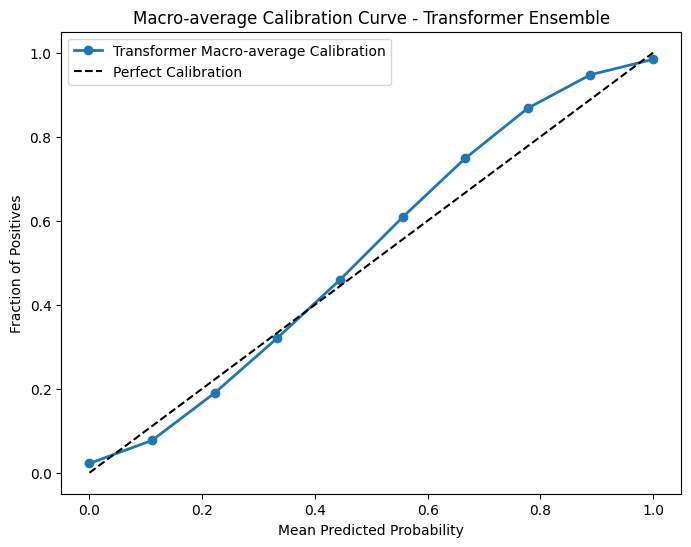

Macro-average Calibration Curve (Fraction values):
[0.02207344 0.07705819 0.18993855 0.32073027 0.45931154 0.60830478
 0.74856423 0.86796143 0.94756904 0.98415451]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_bins = 10
common_pred = np.linspace(0, 1, n_bins)
mean_frac_transformer = np.zeros_like(common_pred)

for i in range(n_classes):
    # 각 클래스별 calibration curve를 보간
    mean_frac_transformer += np.interp(common_pred, calib_pred_transformer[i], calib_frac_transformer[i])
mean_frac_transformer /= n_classes

plt.figure(figsize=(8, 6))
plt.plot(common_pred, mean_frac_transformer, marker='o', lw=2,
         label="Transformer Macro-average Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Macro-average Calibration Curve - Transformer Ensemble")
plt.legend(loc="best")
plt.show()

print("Macro-average Calibration Curve (Fraction values):")
print(mean_frac_transformer)



In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.calibration import calibration_curve

# plt.figure(figsize=(8, 6))
# for i in range(n_classes):
#     fraction_of_positives, mean_predicted_value = calibration_curve(Y_test_bin[:, i], ensemble_transformer_probs[:, i], n_bins=10)
#     plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f"Class {i}")
# plt.plot([0, 1], [0, 1], 'k--', label="Perfectly Calibrated")
# plt.xlabel("Mean Predicted Probability")
# plt.ylabel("Fraction of Positives")
# plt.title("Calibration Curves - Transformer Ensemble")
# plt.legend(loc="best")
# plt.show()
